<a href="https://colab.research.google.com/github/zinebzannouti/DL-CarClassificationWithFlask/blob/main/TL_DL_Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Dataset from Kaggle**



In [1]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

import opendatasets as od
import pandas
od.download("https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zinebzannouti
Your Kaggle Key: ··········


100%|██████████| 1.83G/1.83G [02:04<00:00, 15.8MB/s]


In [3]:
!pip install -q keras
!pip install pyunpack
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.2 MB/s 


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras import optimizers
import efficientnet.keras as efn
from keras.preprocessing import image
from keras import backend as K
from keras.models import model_from_json
from keras.optimizers import Nadam
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import keras
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import scipy.io as sio
import os

In [5]:
batch_size = 32
input_shape = (240,240)
train_dir = '/content/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
test_dir = '/content/stanford-car-dataset-by-classes-folder/car_data/car_data/test'

**Image Preprocessing and Data Augmentation**

In [6]:
#Define train and test datagen with ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[0.9, 1.25],
        brightness_range=[0.5, 1.5],
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
#Define train and test generator
train_generator=train_datagen.flow_from_directory(train_dir,
class_mode="categorical",
target_size=input_shape,
batch_size=batch_size)
validation_generator=test_datagen.flow_from_directory(test_dir,
class_mode="categorical",
target_size=input_shape,
batch_size=batch_size)

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


**Define The model**

*Here we will take the EfficientNetB3 model pretrained on the imagenet dataset and we will transfer the learning to our new model by freezing the EfficientNetB3 model and creating a new model on top.* 

In [8]:
#First instantiate a base model with pre-trained weights.
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False)


44107200/44107200 [==============================] - 7s 0us/step


In [9]:
#Create a new model on top.
#add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
predictions = Dense(196,activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_1[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                           

**Training The model**

In [10]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.samples // batch_size + 1 ,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size + 1,
                    epochs=44,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/44
255/255 [==============================] - 261s 930ms/step - loss: 5.4218 - accuracy: 0.0049 - val_loss: 9.1847 - val_accuracy: 0.0103
Epoch 2/44
255/255 [==============================] - 232s 908ms/step - loss: 5.1286 - accuracy: 0.0124 - val_loss: 4.7869 - val_accuracy: 0.0303
Epoch 3/44
255/255 [==============================] - 233s 912ms/step - loss: 4.6437 - accuracy: 0.0302 - val_loss: 4.3216 - val_accuracy: 0.0532
Epoch 4/44
255/255 [==============================] - 232s 910ms/step - loss: 4.1424 - accuracy: 0.0674 - val_loss: 3.7408 - val_accuracy: 0.1239
Epoch 5/44
255/255 [==============================] - 233s 913ms/step - loss: 3.6882 - accuracy: 0.1094 - val_loss: 3.1896 - val_accuracy: 0.1791
Epoch 6/44
255/255 [==============================] - 232s 910ms/step - loss: 3.2597 - accuracy: 0.1741 - val_loss: 2.9127 - val_accuracy: 0.2191
Epoch 7/44
255/255 [==============================] - 234s 916ms/step - loss: 2.9017 - accuracy: 0.2241 - val_loss: 2.4041 -

**Plot the Accuracy and the loss graphs**

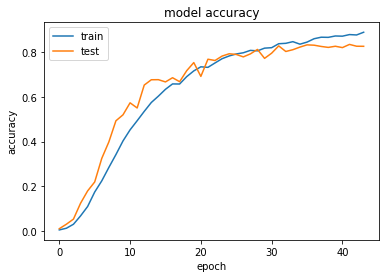

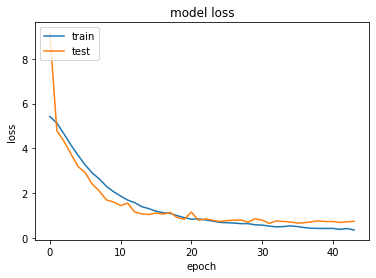

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Fine-tuning**

Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting -- keep that in mind.

It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features.

It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way.

This is how to implement fine-tuning of the whole base model: 

In [12]:
# Unfreeze the base model
base_model.trainable = True

In [13]:
# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=Adam(1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train end-to-end
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.samples // batch_size + 1 ,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size + 1,
                    epochs=10,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
255/255 [==============================] - 251s 930ms/step - loss: 0.3714 - accuracy: 0.8895 - val_loss: 0.6313 - val_accuracy: 0.8526
Epoch 2/10
255/255 [==============================] - 234s 918ms/step - loss: 0.3292 - accuracy: 0.9025 - val_loss: 0.6042 - val_accuracy: 0.8600
Epoch 3/10
255/255 [==============================] - 234s 916ms/step - loss: 0.3029 - accuracy: 0.9037 - val_loss: 0.5840 - val_accuracy: 0.8618
Epoch 4/10
255/255 [==============================] - 234s 916ms/step - loss: 0.2857 - accuracy: 0.9115 - val_loss: 0.5698 - val_accuracy: 0.8648
Epoch 5/10
255/255 [==============================] - 233s 913ms/step - loss: 0.2781 - accuracy: 0.9147 - val_loss: 0.5572 - val_accuracy: 0.8674
Epoch 6/10
255/255 [==============================] - 232s 909ms/step - loss: 0.2591 - accuracy: 0.9181 - val_loss: 0.5435 - val_accuracy: 0.8689
Epoch 7/10
255/255 [==============================] - 232s 909ms/step - loss: 0.2449 - accuracy: 0.9261 - val_loss: 0.5373 -

In [ ]:
#Save the model
model.save('model.h5')

**Confusion Matrix**

In [ ]:
Y_pred = model.predict_generator(validation_generator, validation_generator.samples  // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')

print(classification_report(validation_generator.classes, y_pred))


In [ ]:
cm=confusion_matrix(validation_generator.classes, y_pred)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
category_names = sorted(os.listdir('/content/stanford-car-dataset-by-classes-folder/car_data/car_data/test'))

In [ ]:
plot_confusion_matrix(cm, category_names,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)